#**Data Privacy: Computer Homework 01**


Sharif Univesity of  Technology - EE dept.

by Prof. Yassaee, Fall 2023

Contact *@danialayati* if you have any questions.

*Release Date:* 7 Azar 1402

*Soft Deadline:* 21 Azar 1402 - 23:55

*Hard Deadline:* 25 Azar 1402 - 23:55



---



# *Question 1*: In this question we want to demonstrate membership inference attacks on means by test statistics



First, tuneable simulation parameters:

In [1]:
import numpy as np
from scipy import stats
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import itertools
import opendp

np.random.seed(123)

n_sim =1000
n_samples=10
k_att=100

Then, define utility functions for simulating data and calculating the test statistics:


In [2]:
def synthesize(population_prob, n=1):
  x = np.random.binomial(n=1, p=population_prob, size=(n, len(population_prob)))
  return x

#test statistics:
def test_homer(alice, sample_mean, population_mean):
  test_statistic= sum (abs(alice - population_mean)-abs(alice - sample_mean))
  return test_statistic


def test_dwork(alice, sample_mean, population_mean):
    test_statistic = sum( (alice-population_mean) * (sample_mean-population_mean))
    return test_statistic


def null_distribution (funny, population_prob, population_mean, null_sims=1000, alpha=0.05):
    tests = []

    for _ in range(null_sims):
        sample_mean = synthesize(population_prob, n=n_samples).mean(axis=0)
        null_alice = synthesize(population_prob)[0]
        tests.append(funny(null_alice, sample_mean, population_mean))

    null_dist_vals = np.sort(tests)[::-1]
    return {
        "nulldist": null_dist_vals,
        "critical_val": null_dist_vals[round(alpha * null_sims)]
    }




Create Simple graph function for showing the distribution, partitioned by critical value, then Simulate and graph a null distribution:

In [3]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html
def plot(x, critical_value, name):
    kernel = stats.gaussian_kde(x)
    support_fixed_bounds = np.linspace(min(x), max(x), num=500)
    densities = kernel(support_fixed_bounds)
    partition = np.where(support_fixed_bounds < critical_value, True, False)
    plt.fill_between(support_fixed_bounds[partition], densities[partition])
    plt.fill_between(support_fixed_bounds[~partition], densities[~partition])
    plt.axvline(x=critical_value)
    plt.title(name)
    plt.xlabel("Test Statistic")
    plt.ylabel("Density")
    plt.show()

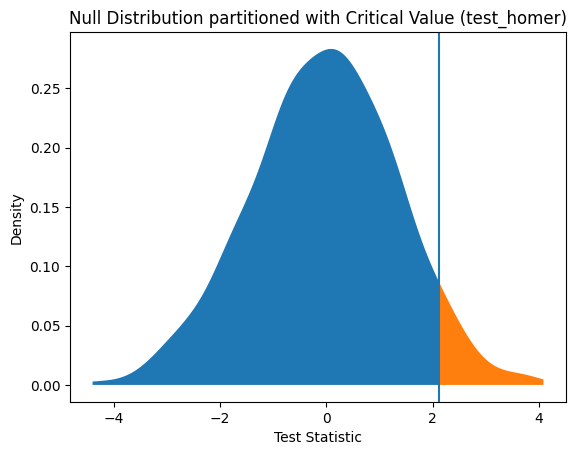

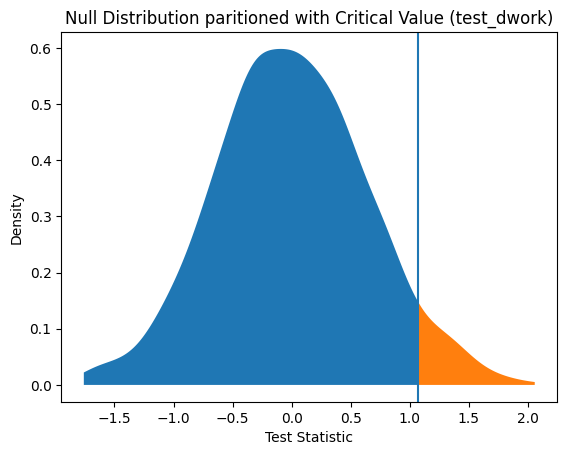

In [4]:
population_prob = np.random.uniform(size=k_att)
population_mean = population_prob

output_homer = null_distribution(test_homer, population_prob, population_mean)
testdist_homer = output_homer["nulldist"]
critical_value_homer = output_homer["critical_val"]
plot(testdist_homer, critical_value_homer, name="Null Distribution partitioned with Critical Value (test_homer)")

output_dwork = null_distribution(test_dwork, population_prob, population_mean)
testdist_dwork = output_dwork["nulldist"]
critical_value_dwork = output_dwork["critical_val"]
plot(testdist_dwork, critical_value_dwork, name="Null Distribution paritioned with Critical Value (test_dwork)")

Now create a complete simulation of attack. We are going to iterate across datasets, calculate the discrimination of the test statistic among observations in the private data and the null population.

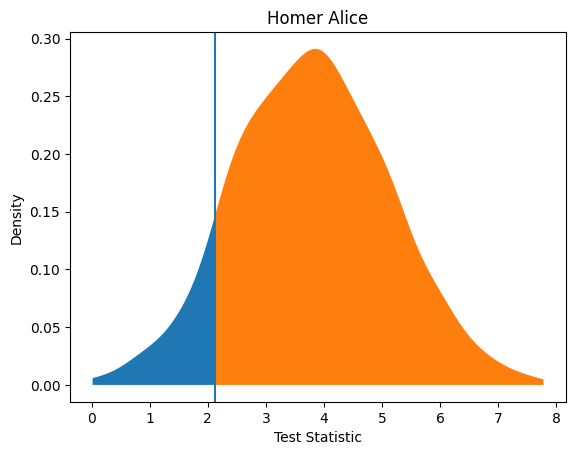

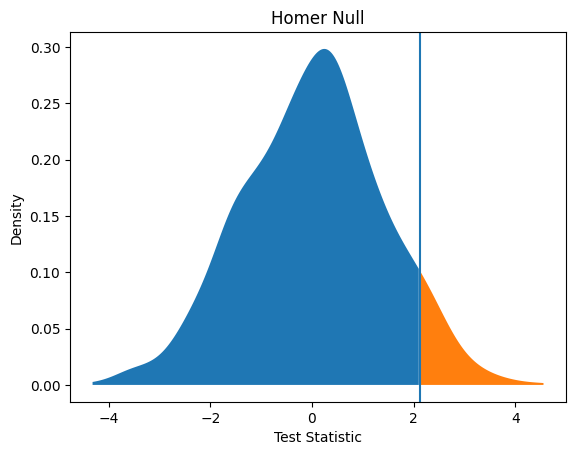

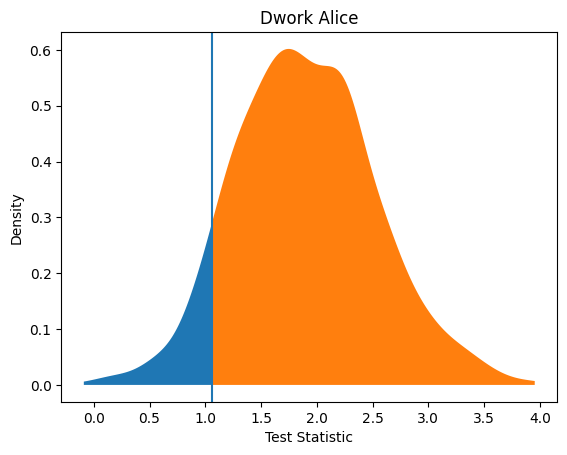

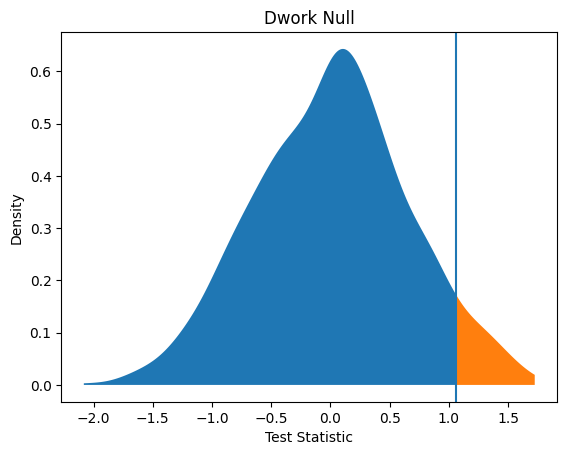

In [5]:
history = np.zeros(shape=(n_sim, 4))

history = np.zeros(shape=(n_sim, 4))

nullDist_Homer = null_distribution(test_homer, population_prob, population_mean)
nullDist_Dwork = null_distribution(test_dwork, population_prob, population_mean)

for i in range(n_sim):
    sample = synthesize(population_prob, n=n_samples)
    sample_mean = sample.mean(axis=0)
    alice = sample[0]
    null_alice = synthesize(population_prob, n=1)[0]

    history[i, 0] = test_homer(alice=alice, sample_mean=sample_mean, population_mean=population_mean)
    history[i, 1] = test_homer(alice=null_alice, sample_mean=sample_mean, population_mean=population_mean)
    history[i, 2] = test_dwork(alice=alice, sample_mean=sample_mean, population_mean=population_mean)
    history[i, 3] = test_dwork(alice=null_alice, sample_mean=sample_mean, population_mean=population_mean)

plot(history[:, 0], critical_value=nullDist_Homer["critical_val"], name="Homer Alice")
plot(history[:, 1], critical_value=nullDist_Homer["critical_val"], name="Homer Null")

plot(history[:, 2], critical_value=nullDist_Dwork["critical_val"], name="Dwork Alice")
plot(history[:, 3], critical_value=nullDist_Dwork["critical_val"], name="Dwork Null")




---



# *Question 2:* Now Let's bulid  Laplace Mechanism for Differential Privacy

First, construct the basic building blocks for a Laplace mechanism, a random sampler from the distribution, a clamp/clip/censor function, the function for the true mean, and then the DP release algorithm itself.

In [6]:
#Laplace:
def laplace(shift=0., scale=1., size=None):
  return np.random.laplace(loc=shift, scale=scale, size=size)

#Clamp:
def clamp(x, bounds):
  return np.clip(x, *bounds)

#bounded mean:
def bounded_mean(x, bounds):
  return np.mean(clamp(x,bounds))

#dp mean:
def release_dp_mean_laplacian(x, epsilon, bounds):
  return laplace(shift=bounded_mean(x, bounds), scale=(bounds[1] - bounds[0]) / (len(x) * epsilon))


Read in the data.  We're going to use the PUMS dataset, and focus on the education variable, a 16 point scale:

In [7]:
data = pd.read_csv(
    "https://raw.githubusercontent.com/opendp/cs208/main/spring2022/data/FultonPUMS5full.csv")

n = len(data)
educ_bounds = (1., 16.)

educ = data['educ'].values.astype(float)
print(release_dp_mean_laplacian(educ, bounds=educ_bounds, epsilon=1.))


10.609533032405645


Now that we have a mechanism available, let's try a new one, the histogram.  Histograms give counts of the number of observations within defined partitions of the variable domain.  Consider carefully the sensitivity for the histogram, which depends on which definition of neighbouring we are using. After that,  call your privacy-preserving histogram.

In [8]:
from collections import Counter

def release_histogram(x, epsilon, categories):
  sensitivity = 2
  scale = sensitivity/epsilon

  counts = {category: count for category, count in Counter(x).items()}

  categories = list(set(x))
  vectorized_get_count = np.vectorize(counts.get)
  sensitive_histogram = vectorized_get_count(categories)

  dp_histogram = sensitive_histogram + laplace(scale=scale, size=sensitive_histogram.shape)
  return dp_histogram

Now we want to to simulate repeated draws from the Laplace mechanism to examine the utility it offers over the range of epsilon values and dataset sizes, for our education variable. We'll need a way to construct new datasets, given we only have one available.  The (nonparametric) bootstrap function lets us construct datasets even larger than our original source data if needed, by treating the sample data as if it is a population from which we can resample.

In [9]:
def bootstrap(x, n):
    return np.random.choice(x, size=n)

log_seq = np.linspace(start=math.log10(200), stop=math.log10(1500), num=15)
number_of_iters = (10**log_seq).astype(int)

log_seq = np.linspace(start=math.log10(1), stop=math.log10(0.1), num=5)
epsilons = (10**log_seq *100).astype(int)/100

agg_history = []

for num, epsilon_sim in itertools.product(number_of_iters, epsilons):
    sq_error = 0

    for k in range(num):
        bootdata = bootstrap(educ, n_sim)
        sensitive_mean = bounded_mean(x=bootdata, bounds=educ_bounds)
        dp_mean = release_dp_mean_laplacian(x=bootdata, bounds=educ_bounds, epsilon=epsilon_sim)
        sq_error += (dp_mean - sensitive_mean) ** 2

    agg_history.append([
        n_sim,
        epsilon_sim,
        np.sqrt(sq_error/num)
    ])

agg_history = pd.DataFrame(agg_history, columns=["N", "epsilon", "error"])

Now graph your resluts!

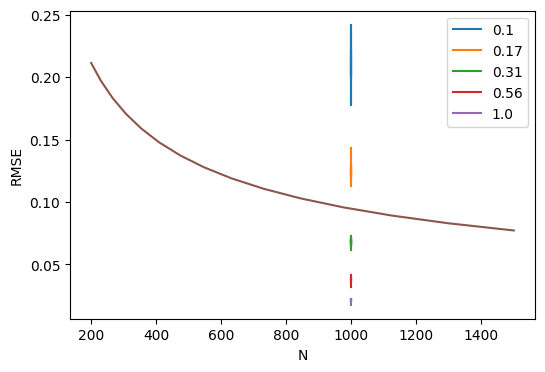

In [10]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.set_ylabel("RMSE")

for epsilon_sim, subhistory in agg_history.groupby("epsilon"):
    subhistory.plot(x="N", y="error", label=epsilon_sim, ax=ax, legend=None)

se = np.std(educ) / np.sqrt(number_of_iters)
ax.plot(number_of_iters, se)

_ = ax.legend()

plt.show()



---



# *Question 3:* OPENDP

The OpenDP Project is a community effort to build trustworthy, open source software tools for analysis of private data. The core software of the OpenDP Project is the OpenDP Library.

The OpenDP Library is a modular collection of statistical algorithms that adhere to differential privacy. The library is based on a conceptual framework described in [A Programming Framework for OpenDP](https://projects.iq.harvard.edu/files/opendp/files/opendp_programming_framework_11may2020_1_01.pdf).

The OpenDP Library can be found on GitHub: https://github.com/opendp/opendp/

OpenDP represents computations with Transformations and Measurements. First, recall all you need from opendp, then create a measurement that simply addds laplace noise and like a function.

In [12]:
from opendp.mod import enable_features, Transformation, Measurement
from opendp.meas import *
from opendp.trans import *
from opendp.typing import *

enable_features("contrib", "floating-point")

#Laplace
def add_laplace(x, scale = 1.0):
  return x >> make_base_laplace(scale)

#Gaussian
def add_gaussian(x, scale = 1.0):
  return x >> make_base_gaussian(scale)

#Geometric
def add_geometric(x, scale = 1.0):
  return x >> make_base_geometric(scale)


We can also chain transformations and measurements. You might already think of chaining as function composition. The reason why we call it "chaining," instead of "composition," is because composition has a special meaning in differential privacy. In the context of differential privacy, composition refers to the joint release of more than one measurement.

In [13]:
sized_bounded_mean: Transformation = make_sized_bounded_mean(size=n, bounds=educ_bounds)
sized_bounded_mean(arg=educ)
base_laplace: Measurement = make_base_laplace(scale=0.5)
# chain with the base_laplace measurement
dp_mean: Measurement = sized_bounded_mean >> base_laplace

# release a dp mean
dp_mean(arg=educ)

7042878440.417729

Now that we've shown how to build up computations and execute them, lets talk about distances.

Transformations and Measurements relate distances. There are three kinds of distances:

1. Dataset distances  
    (greatest distance between neighboring datasets)
1. Sensitivities  
    (greatest distance between queries on neighboring datasets)
1. Privacy budget    
    (greatest distance between the probability distributions)

The following shows how the `base_laplace` measurement relates a `sensitivity` to a privacy budget, `epsilon`.

In [ ]:
# Check that when sensitivity is 0.15, the privacy usage is .30
make_base_laplace.check(d_in=.15, d_out=.30)

We can interpret this as: If the sensitivity is .15, then we could release the query answer with `laplace(scale=.5)` noise at a privacy expenditure of `.3 epsilon`. Equivalently, this data release is `.3 differentially private`, or `.3-DP`, where the privacy units are implicitly in terms of epsilon.

If we were to increase the sensitivity, the same relation would fail, and the release would not be `.3-DP`.

In [14]:
base_laplace.check(d_in=.22, d_out=.3)

False

As you might expect, the relation will also pass for any sensitivity that is smaller, or any privacy expenditure that is larger. And similarly, the `sized_bounded_mean` transformation relates a dataset distance `max_influence` to a `sensitivity`.

In [19]:
print(base_laplace.check(d_in=.12, d_out=.37))
print(base_laplace.check(d_in=.08, d_out=.53))
print(base_laplace.check(d_in=.14, d_out=.88))

True
True
True


Now relate distances on chained computations. The units for the input and output distances come from the constituent transformations and measurements.

For example, when we chain the `sized_bounded_mean` transformation and `base_laplace` measurement together, the input distance is a dataset distance, `max_influence`, and the output distance is measured in terms of a privacy budget, `epsilon`.

In [20]:
max_influence = 2
sized_bounded_mean.check(d_in=max_influence, d_out=.15)

True

The `release_histogram` function behaves similarly to the `make_count_by_categories` function in OpenDP.

In [ ]:
help(make_count_by_categories)

In [27]:
# release a histogram with laplace noise
educ_categories = list(range(1, 17))
output = release_histogram(educ, epsilon=1., categories=educ_categories)
dp_histogram_laplace = (
    make_count_by_categories(categories=educ_categories, TOA=float, MO=L1Distance[float]) >>
    make_base_laplace(scale=1., D=VectorDomain[AllDomain[float]])
)
dp_histogram_laplace(educ.astype(np.int32))

[273.57035997696113,
 141.06894420496155,
 357.63275970168576,
 468.94557691737566,
 499.9919497395322,
 757.2674261340928,
 892.2605862700347,
 1058.5404074307341,
 5145.456622241273,
 1394.5089481328505,
 3961.8888176123655,
 1154.2505065126174,
 6283.925365724448,
 2267.930569748961,
 794.1860773413065,
 309.9525631792972,
 1.5560031164642216]

In [28]:
# release a histogram with geometric noise
dp_histogram_geometric = (
    make_count_by_categories(categories=educ_categories) >>
    make_base_geometric(scale=1., D=VectorDomain[AllDomain[int]])
)
dp_histogram_geometric(educ.astype(np.int32))

[271,
 141,
 357,
 469,
 496,
 759,
 894,
 1060,
 5146,
 1394,
 3963,
 1155,
 6285,
 2269,
 795,
 309,
 2]



---



# *Question 4:* Gaussian Mechanism

Let's extend the basic building blocks to include a Gaussian mechanism and a random sampler from the Gaussian.

In [23]:
def gaussian(shift=0., scale=1., size=None):
    draws = np.random.normal(loc=shift, scale=scale, size=size)
    return draws

def release_dp_mean_gaussian(x, bounds, epsilon, delta=1e-6):
    return gaussian(shift=bounded_mean(x, bounds), scale=(bounds[1] - bounds[0]) / (len(x) * epsilon))


Read in the data. We are using the familiar PUMS dataset we are familiar with, and focusing on the education variable, a 16 point scale.

In [24]:
data = pd.read_csv(
    "https://raw.githubusercontent.com/opendp/cs208/main/spring2022/data/FultonPUMS5full.csv")

n = len(data)
educ_bounds = (1., 16.)

educ = data['educ'].values.astype(float)
print(release_dp_mean_gaussian(educ, bounds=educ_bounds, epsilon=1.))


10.608776107975059


Now simulate repeated draws from both mechanisms to compare the utility they offer over a range of epsilon values and dataset sizes.  

In [25]:
log_seq = np.linspace(start=math.log10(200), stop=math.log10(1500), num=15)
number_of_iters = (10**log_seq).astype(int)

log_seq = np.linspace(start=math.log10(1), stop=math.log10(0.1), num=5)
epsilons = (10**log_seq *100).astype(int)/100

agg_history = []

for num, epsilon_sim in itertools.product(number_of_iters, epsilons):
    sq_error_laplace = sq_error_gaussian = 0

    for k in range(num):
        bootdata = bootstrap(educ, n_sim)
        sensitive_mean = bounded_mean(x=bootdata, bounds=educ_bounds)
        dp_mean_laplace = release_dp_mean_laplacian(x=bootdata, bounds=educ_bounds, epsilon=epsilon_sim)
        dp_mean_gaussian = release_dp_mean_gaussian(x=bootdata, bounds=educ_bounds, epsilon=epsilon_sim)
        sq_error_laplace += (dp_mean_laplace - sensitive_mean) ** 2
        sq_error_gaussian += (dp_mean_gaussian - sensitive_mean) ** 2

    agg_history.append([
        n_sim,
        epsilon_sim,
        np.sqrt(sq_error_laplace/ num),
        np.sqrt(sq_error_gaussian/ num)
    ])

agg_history = pd.DataFrame(agg_history, columns=["N", "epsilon", "laplace error", "gaussian error"])

And Finally Graph your result:

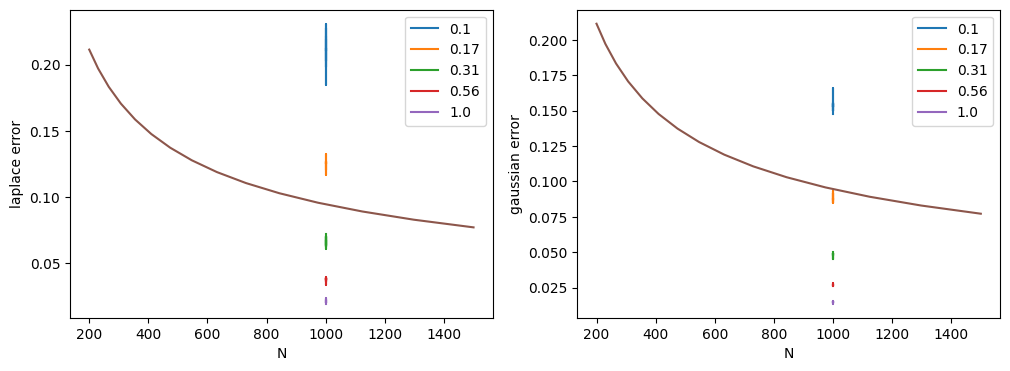

In [26]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))

for i, error_type in enumerate(["laplace error", "gaussian error"]):
    ax = axs[i]
    ax.set_ylabel(error_type)

    for epsilon_sim, subhistory in agg_history.groupby("epsilon"):
        subhistory.plot(x="N", y=error_type, label=epsilon_sim, ax=ax, legend=None)

    se = np.std(educ) / np.sqrt(number_of_iters)
    ax.plot(number_of_iters, se)

    _ = ax.legend()

plt.show()